In [1]:
%matplotlib inline
## IMPORTS ##
import numpy as np
import math as mth
from matplotlib import pyplot as plt
from matplotlib import cm as cm
from matplotlib import colors as col
import healpy as hp
from matplotlib.colors import LogNorm

ModuleNotFoundError: No module named 'healpy'

# Dispersion Measures of Pulsars

As a pulse from a pulsar travels through space, it passes through free 'ionised' electrons in the interstellar medium.

These electrons cause the pulse arrival time at an observer to be delayed as a function of frequency: lower frequencies arrive later than higher frequencies. The effect is known as dispersion delay. The delay between two frequencies ($f_1$, $f_2$) and follows the equation:

$\Delta t\simeq4.15\times10^6$ ms $\times(f_1^{-2}-f_2^{-2})\times DM$

Where $DM$ is known as the dispersion measure.

The observed effect on a pulse is a characteristic sweep as a function of frequency.

## An observed, dispersed, pulsar

Below we plot some data representing a pulsar observation. This pulsar has been dispersed.

In [2]:
# this code imports the full version
#stride = 8
#obs=np.loadtxt('frb_noise.txt')[::stride,:]
#np.save = np.save('frb_noise.npy',obs)
# we will use a downsampled version
# to speed up processing
obs = np.load('data/frb_noise.npy')

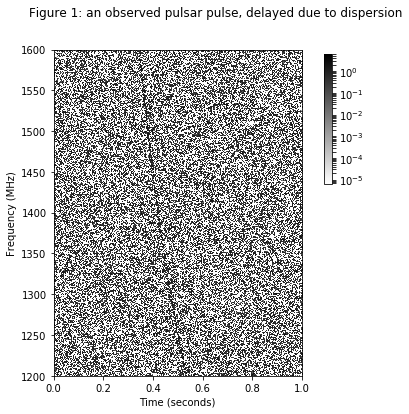

In [3]:
#define necessary constants (don't change these): 
b=400*(10**(-3))   # Frequency bandwidth of observation in GHz
mf=1200*(10**(-3)) # Minimum frequency of observation in GHz
st=5e-05 * 8          # Sampling time of observation in seconds
nt=np.size(obs,0)  # Number of times sampled during observation

#initialise plot
fig=plt.figure(figsize=(6,6))
fig.suptitle('Figure 1: an observed pulsar pulse, delayed due to dispersion',fontsize=12)
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('Frequency (MHz)')

extent = [0,nt*st,(mf)/(10**-3),(mf+b)/(10**-3)]
#plot original observation
im1 = ax1.imshow(obs.T,cmap='binary',aspect='auto',origin='lower',extent=extent, norm=col.LogNorm())

#colorbar
fig.subplots_adjust(right=0.7,wspace=0.8)
cbar_ax1 = fig.add_axes([0.75,0.57,0.02,0.3])
fig.colorbar(im1,cax=cbar_ax1)

plt.show()

## The dispersion measure (DM)

The dispersion measure is an important tool in pulsar astronomy. Its definition is:

$DM = \int^d_0 n_e dl$

Where $d$ is the distance between a pulsar and its observer, and $n_e$ is the electron density along the sightline. In words, DM is equal to the integrated electron column density along the line of sight, which essentially means it represents the total number of free electrons a pulse has passed through between the source and observer.

Because we know the relationship between DM and the delay of a pulse at a particular frequency, we can undo the using the correct DM.



## Why does DM matter?

The DM of a pulsar is a useful tool. Among other things, it allows us to estimate the distance to an observed source. If we assume $n_e$, the electron column density along the line of sight between source and observer to be constant, then for any given pulsar we observe, we can calculate its distance based on its location in the sky. All we need is a value for $n_e$.

Luckily, models such as NE2001 exist, which estimate $n_e$ along sightlines in the sky. These models are created using pulsars with known DMs and known distances, which are derived in other ways (for example using parallax measurements).

Below we plot the NE2001 model for the entire sky. Running horizontally along the center of the map is the Galactic Plane -- imagine you were looking at our Milky Way side-on.

The color refers to $n_e$, the electron density, at any particular galactic coordinate - you will see that close to the Galactic Plane of our Milky Way $n_e$ is much higher. Further from the Galactic Plane and Galactic Center, there are less stars, less matter, less ionised electrons, and thus, $n_e$ is smaller.

### The NE2001 model

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


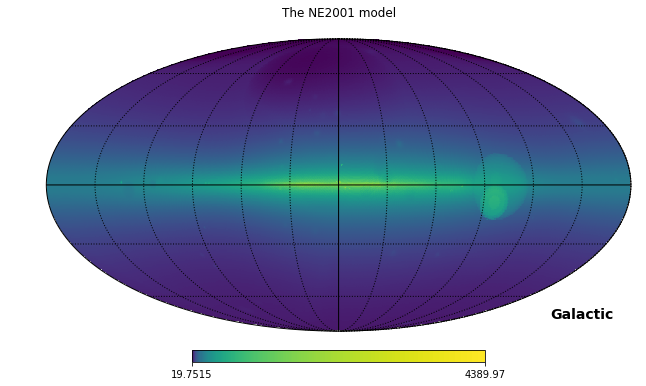

In [4]:
#load ne2001 data
NE2001_data=np.loadtxt('data/NE2001DMs_for_NSIDE_128.txt_backup',dtype=str)

#initialise arrays for healpix plot
nside_ne2001 = np.array([float(NE2001_data[i][0]) for i in range(len(NE2001_data))])

#plot map of NE2001 model
hp.mollview(nside_ne2001,title="The NE2001 model\n",norm='log',coord=['C','G'], return_projected_map=True)
hp.graticule()


## Dedispersing a pulsar

Below, we show what happens when we dedisperse a pulsar by guessing its DM.

### Pick a DM

In [5]:
DM = 130 #note, choose something 250 or less for now

### Dedisperse the pulse

#### Functions

In [6]:
def dedisperse(dispersed_image,dispersion_measure,bandwidth,minfreq,sample_time):
    """
    Dedisperses an array containing a pulsar pulse.
    
    Note: the input image must have layout:
    columns -> frequencies (increasing), rows -> time (increasing)
    
    INPUTS:
    
    dispersed_image    : (array-like) a 2D array of frequencies and times to dedisperse
    dispersion_measure : (float) a DM to dedisperse the image at [pc cm^{-3}]
    bandwidth          : (float) the bandwidth of the observation [GHz]
    minfreq            : (float) the minimum frequency observed [GHz]
    sample_time        : (float) the sampling time of the observation [s]
    
    OUTPUTS:
    
    dedispersed_image : (array-like) the dedispersed image
    maxroll           : (int) the number of time samples which have rolled
                              from the end to the beginning of the observation
                              due to array manipulation. These should be cropped
                              before plotting, as they make no physical sense
    """
    
    #set necessary constants
    dedispersed_image=np.zeros_like(dispersed_image,dtype=float)
    const=4.148808*(10**(-3)) #s
    maxfreq=minfreq+bandwidth
    nchannels=np.size(dispersed_image,1)
    #dedisperse image
    for i in range(0,nchannels):
        #dispersion time
        delta_T=const*(((minfreq+(i*bandwidth/nchannels))**(-2))-((maxfreq))**(-2))*dispersion_measure #s
        #convert to number of elements in array to roll back
        #(1 element = sample time, so 1 second = (1/sample time) elements)
        rollback=(delta_T)*(1/((sample_time)))
        #get the maximum rollback for cropping dedispersed array
        if i==0:
            maxroll=int(round(rollback))
        #roll back the elements
        dedispersed_image[:,i]=np.roll(dispersed_image[:,i],-int(round(rollback)))
    
    np.apply_along_axis
    return(dedispersed_image,maxroll)


def crop(dedispersed_image,maxroll):
    """
    Crop time samples from dedispersed image which, after dedispersion,
    rolled from the end of the observation to the beginning.
    
    INPUTS:
    
    dedispersed_image : (array-like) the dedispersed image
    maxroll           : (int) the number of time samples which have rolled
                              from the end to the beginning of the observation
                              due to array manipulation. These should be cropped
                              before plotting, as they make no physical sense.
                              
    OUTPUTS:
    
    cropped_image : (array-like) cropped version of input image.
    
    """
    
    cropped_image=dedispersed_image[maxroll:-maxroll,:]

    return cropped_image


#### Execute and plot

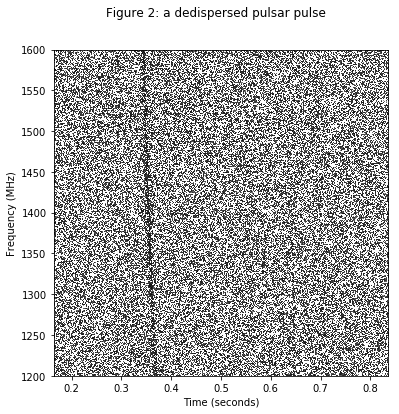

In [7]:
#dedisperse observed pulse
dedispersed_obs,mroll = dedisperse(obs,DM,b,mf,st) # dedisperse
dedispersed_obs = crop(dedispersed_obs,mroll)      # crop rollover

#initialise plot
fig=plt.figure(figsize=(6,6))
fig.suptitle('Figure 2: a dedispersed pulsar pulse',fontsize=12)
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('Frequency (MHz)')

# define the scaling parameters
extent = [(mroll*st),((nt*st)-(mroll*st)),(mf)/(10**-3),(mf+b)/(10**-3)]
#plot dedispersed pulse
im1=ax1.imshow(dedispersed_obs.T,cmap=cm.Greys,aspect='auto',origin='lower',extent=extent,norm=col.LogNorm())

#colorbar
#fig.subplots_adjust(right=0.7,wspace=0.8)
#cbar_ax1 = fig.add_axes([0.75,0.57,0.02,0.3])
#fig.colorbar(im1,cax=cbar_ax1)

plt.show()

## How do we know which DM to use?

At the time of arrival, the pulse will be brighter than any background noise observed by a telescope.

For a perfectly dedispersed pulse, summing the power over all frequencies at any given time will result in random noise, and at the time of the pulse, a bright spike containing all the pulse's power.

For a dispersed pulse, the pulse power is spread over a large time, and so the pulse will be harder to spot. 

#### Functions

In [8]:
def collapse(cropped_image,sample_time,maxroll):
    """
    Collapses (sums) a cropped image into a 1-dimensional array over the frequency axis.
    Can be used to find the peak signal in the image vs time.
    
    INPUTS:
    
    cropped_image : (array-like) a 2D array of times (axis 0) and frequencies (axis 1) to collapse
    sample_time   : (float) the sampling time of the observation [s]
    maxroll       : (int) the number of time samples which have rolled
                          from the end to the beginning of the observation
                          due to array manipulation. These should be cropped
                          before plotting, as they make no physical sense.
    
    OUTPUTS:
    
    times     : (array-like) times to plot against collapsed observation
    collapsed : (array-like) observation, collapsed over frequency axis
    
    """
    
    #create array of sample times
    times=np.arange(0+maxroll,np.size(cropped_image,0)+maxroll)*sample_time
    
    #create collapsed array of signals by summing over frequencies
    collapsed=np.sum(cropped_image,axis=1)
    
    return times,collapsed

#### Execute and plot

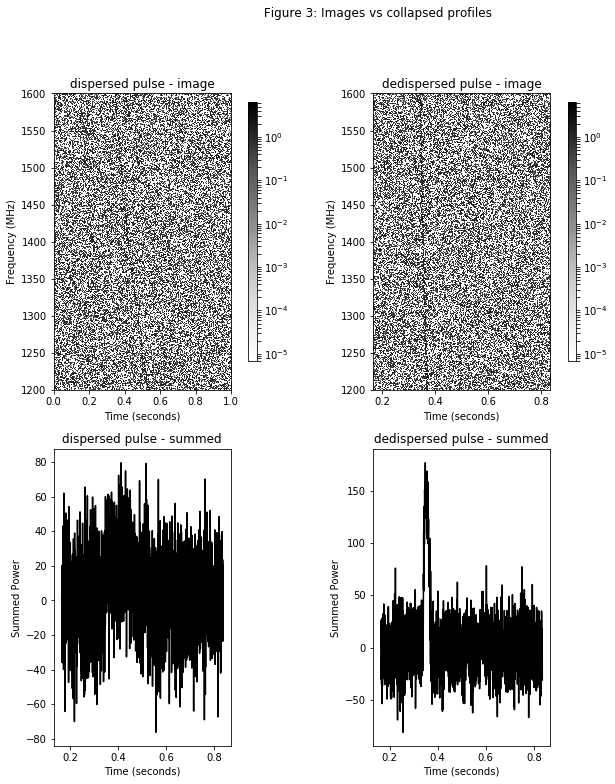

In [9]:
#collapse the original pulse
obs_cropped=crop(obs,mroll) #crop the original observation
obs_t,obs_signal=collapse(obs_cropped,st,mroll)

#collapse the dedispersed pulse
dedispersed_t,dedispersed_signal=collapse(dedispersed_obs,st,mroll)

#plot
fig=plt.figure(figsize=(12,12))

#axes
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

#titles
fig.suptitle('Figure 3: Images vs collapsed profiles', fontsize=12)
ax1.set_title('dispersed pulse - image')
ax2.set_title('dedispersed pulse - image')
ax3.set_title('dispersed pulse - summed')
ax4.set_title('dedispersed pulse - summed')

#xlabels
ax1.set_xlabel('Time (seconds)')
ax2.set_xlabel('Time (seconds)')
ax3.set_xlabel('Time (seconds)')
ax4.set_xlabel('Time (seconds)')

#ylabels
ax1.set_ylabel('Frequency (MHz)')
ax2.set_ylabel('Frequency (MHz)')
ax3.set_ylabel('Summed Power')
ax4.set_ylabel('Summed Power')

#plots
im1 = ax1.imshow(obs.T,cmap=cm.Greys,aspect='auto',origin='lower',extent=[0,nt*st,(mf)/(10**-3),(mf+b)/(10**-3)], norm=col.LogNorm())
im2 = ax2.imshow(dedispersed_obs.T,cmap=cm.Greys,aspect='auto',origin='lower',extent=[(mroll*st),((nt*st)-(mroll*st)),(mf)/(10**-3),(mf+b)/(10**-3)],norm=col.LogNorm())
im3 = ax3.plot(obs_t,obs_signal,label='signal',color='k')
im4 = ax4.plot(dedispersed_t,dedispersed_signal,label='signal',color='k')

#colorbars
fig.subplots_adjust(right=0.7,wspace=0.8)
cbar_ax1 = fig.add_axes([0.35,0.57,0.01,0.3])
cbar_ax2 = fig.add_axes([0.72,0.57,0.01,0.3])
fig.colorbar(im1,cax=cbar_ax1)
fig.colorbar(im2,cax=cbar_ax2)

plt.show()


## Pulse Signal-to-noise (S/N)

The closer you are to correctly guessing the DM of the pulsar, the higher it will stand out above background noise.

The signal to noise of our dedispersed pulse is shown below.

#### Functions

In [10]:
def Sig_To_Noise(times,data,peakwidthestimate=100):
    """
    Get signal to noise ratio for timeseries data containing a peak.
    Uses an estimate of the peak width in bins, so it can be removed to get a more accurate noise estimate.
    
    INPUTS:
    
    times             : (array-like) times of input data
    data              : (array-like) timeseries data containing a peak
    peakwidthestimate : (int) estimate width of peak in bins
    
    OUTPUTS:
    
    SN      : (float) signal to noise ration of peak
    avnoise : (float) average value of noise in input array
    
    """
    
    #find the peak in the data
    peak=np.amax(data)
    peak_index=np.where(data[:]==peak)
    peak_index=peak_index[0][0]
    peak_time=times[peak_index]
    #remove the signal from the peak
    signal_removed=np.concatenate([data[0:(peak_index-(peakwidthestimate//2))],data[(peak_index+(peakwidthestimate//2)):len(data)]])
    #calculate average noise
    avnoise=np.sum(signal_removed)/len(signal_removed)
    #calculate rms of noise
    rmsnoise=np.sqrt(np.mean(signal_removed**2))
    #calculate S/N ratio
    SN=(peak-avnoise)/rmsnoise
    
    return SN,avnoise

def findpeakinfo(times,data):
    """
    Find a peak in timeseries data.
    
    INPUTS:
    
    times             : (array-like) times of input data
    data              : (array-like) timeseries data containing a peak
    
    OUTPUTS:
    
    peak_time : (float) time of the peak
    peak      : (float) value of the peak
    
    """

    peak=np.amax(data)
    peak_index=np.where(data[:]==peak)
    peak_time=times[peak_index]

    return peak_time,peak


#### Execute and plot

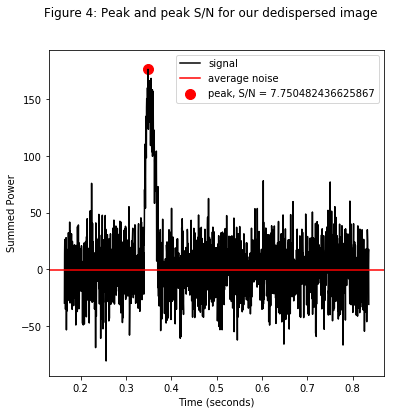

In [11]:
#calculate signal and noise
dedispersed_SN,dedispersed_avnoise=Sig_To_Noise(dedispersed_t,dedispersed_signal,100)

#find peak
dedispersed_peaktime,dedispersed_peak = findpeakinfo(dedispersed_t,dedispersed_signal)

#initialise plot
fig=plt.figure(figsize=(6,6))
fig.suptitle('Figure 4: Peak and peak S/N for our dedispersed image',fontsize=12)
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('Summed Power')

#plot signal
im1 = ax1.plot(dedispersed_t,dedispersed_signal,label='signal',color='k')
#plot average noise
im1 = ax1.axhline(dedispersed_avnoise,color='r',label='average noise')
#plot peak
im1 = ax1.scatter(dedispersed_peaktime,dedispersed_peak,color='r',s=100,label='peak, S/N = {}'.format(dedispersed_SN))

plt.legend()
plt.show()


## Signal to noise variation with trial DM

By trialling many different DMs and searching for the peak with the highest S/N, we can estimate the true DM of the pulsar:

#### Functions

In [12]:
def dDM_step(dispersed_image,timestep,minfreq,bandwidth):
    """
    Get optimum dDM step size for trialling DMs.
    Note: this function takes in GHz and converts to MHz before calculating,
    and also converts the timestep from s to ms
    
    INPUTS:
    
    dispersed_image : (array-like) a 2d array of frequencies and time samples containing a dispersed pulse
    timestep        : (float) the sampling time of the array [seconds]
    minfreq         : the minimum frequency of the observation [Hz]
    bandwidth       : the bandwidth of the observation [Hz]
    
    OUTPUTS:
    
    dDM : the DM step size to use when trialling dispersion measures to find pulse [pc cm^{-3}]
    """
    
    nchannels=float(np.size(dispersed_image,1)) # number of channels in array
                    
    lower_freq=((((minfreq+bandwidth)/(nchannels))*(nchannels/2)))*(10**(-3))     # convert lower frequency to MHz
    upper_freq=((((minfreq+bandwidth)/(nchannels))*((nchannels+1)/2)))*(10**(-3)) # convert upper frequency to MHz
    timestep=timestep*(10**(3))                                                   # convert sampling time to ms
    const = 4.148808*(10**(6))                                                    # from pulsar handbook eq 4.7
    dDM = timestep/(const * ((lower_freq*(10**(-2)))-(upper_freq*(10**(-2)))))    # calculate dDM
    dDM=np.abs(dDM)
    
    return dDM

#### Execute and plot

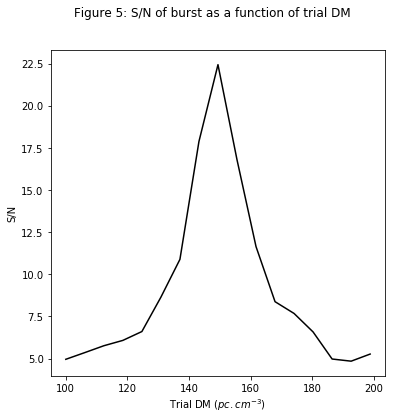

In [13]:
#calculate DM step size to trial
dDMstep=dDM_step(obs,st,mf,b)
                    
#set list of DMs to trial over
DMs=np.arange(100,200,dDMstep)

#initialise arrays 
Sig_To_Noises=np.zeros_like(DMs,dtype=float) # signal-to-noise
Peak_Times=np.zeros_like(DMs,dtype=float)    # times of peaks
Peaks=np.zeros_like(DMs,dtype=float)         # peak values
                    
#calculate signal to noises for each trial DM
for i in range(len(DMs)):                                 # loop over DMs
    cleaned,mroll=dedisperse(obs,DMs[i],b,mf,st)          # dedisperse original observed pulse
    cropped=crop(cleaned,mroll)                           # crop rollover
    t,signal=collapse(cropped,st,mroll)                   # collapse the image to a 1d array
    pkt,pk=findpeakinfo(t,signal)                         # find peak, peak time of dispersion trial
    Peak_Times[i]=pkt[0]                                  # append peak time to array
    Peaks[i]=pkt                                          # append peak value to array
    Sig_To_Noises[i],average_noise=Sig_To_Noise(t,signal) # append signal-to-noise to array

#plot signal to noise as a function of trial DM


#initialise plot
fig=plt.figure(figsize=(6,6))
fig.suptitle('Figure 5: S/N of burst as a function of trial DM',fontsize=12)

ax1 = fig.add_subplot(111)
ax1.set_xlabel('Trial DM ($pc.cm^{-3}$)')
ax1.set_ylabel('S/N')

#plot
im1=ax1.plot(DMs,Sig_To_Noises,color='k')

plt.show()

## What is our Pulsar's true DM?

In [14]:
#find DM with best S/N
bestSN=np.amax(Sig_To_Noises)
#find index of largest S/N
bestpeakindex=np.where(Sig_To_Noises[:]==bestSN)
#find associated peak
bestpeak=Peaks[bestpeakindex]
#find time of largest peak
bestpeaktime=Peak_Times[bestpeakindex]
#find best DM
bestDM=DMs[bestpeakindex]

#print results
print('Optimum dispersion measure: {}\n Peak value: {}\n Time: {} seconds\n S/N: {}'.format(bestDM,bestpeak,bestpeaktime,bestSN))


Optimum dispersion measure: [ 149.36357624]
 Peak value: [ 0.3436]
 Time: [ 0.3436] seconds
 S/N: 22.444540089785644
